In [65]:
using Plots, LinearAlgebra, SparseArrays

## Exercise 1. Spectral Methods.

I'll be using [ApproxFun](https://github.com/JuliaApproximation/ApproxFun.jl) which is very similar to `chebfun` but is in julia.

In [66]:
using  ApproxFun

In [215]:
# Defining Domain and Other ApproxFun objects
x = Fun(identity, Chebyshev(Interval(0.0,1.0)))
d = domain(x)
D = Derivative()
B = Dirichlet()

# Defining LHS
A = [B;
    - D*((1+x^2)*D)] # Defining the operator

# Defining RHS
b_boundary = [0.0 , 0.0] # u(0) = 0, u(1) = 0
b_forcing = [ 6*x^2 - 2*x + 2] # Forcing f(x)

# First equation will satisfy Dirichlet BC == b_boundary
# Second equation will satisfy Operater == Forcing
# We then solve using Backslash
u = A \ [b_boundary, b_forcing ]

Fun(Chebyshev(0.0..1.0),[0.125, -4.337646907243555e-18, -0.125, 9.219382189774801e-19, -1.2254981311325304e-19, -8.390883395346276e-21, 5.098224702976462e-21, -5.76816300010391e-22, 9.248701851716379e-23])

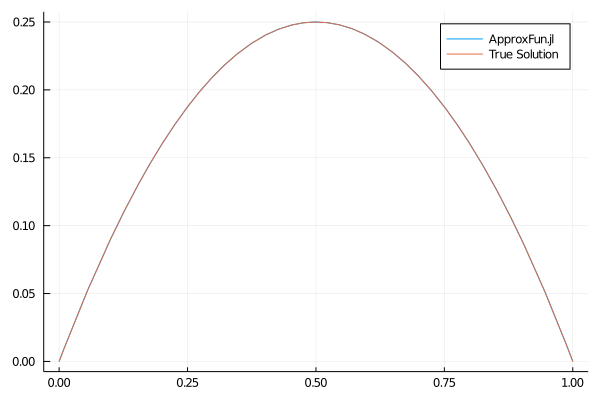

In [216]:
plot(t -> u(t), 0, 1,
    label = "ApproxFun.jl")
plot!(x -> x*(1-x), 0, 1,
    label = "True Solution")

In [217]:
true_u = Fun(x*(1-x), d)

Fun(Chebyshev(0.0..1.0),[0.125, 0.0, -0.125])

In [218]:
# 2-norm is:
norm(u - true_u, 2)

2.8794101375170395e-18

In [219]:
# Infinity-norm is:
norm(u - true_u, Inf)

3.89052005832565e-18

## Exercise 2. Poisson's equation.

There are a lot strange matrix flips and rotations here so that the heatmaps look right. Sorry if things end up transpoosed!

In [220]:
function makePoissonA(m)
    h = 1/(m+1)    
    T = Tridiagonal(ones(m-1), -4*ones(m), ones(m-1))
    S = Tridiagonal(ones(m-1), -zeros(m), ones(m-1))
    A = (kron(I(m), T) + kron(S, I(m))) / h^2
    return A
end

makePoissonA (generic function with 1 method)

In [221]:
function makePoissonf(m) 
    F = zeros(m,m)
    h = 1/(m+1)
    #n = 0
    for i in 1:m
        for j in 1:m
            F[i,j] = (i*h)^2 + (j*h)^2 #x^2 + y^2
        end
    end
    
    # Add in Dirichlet Boundary Condititions
    for i in 1:m
        F[i, 1] -= 1/h^2
        F[i, end] -= 1/h^2
        F[1, i] -= 1/h^2
        F[end,i] -= 1/h^2
    end
    
    return reverse(F, dims = 1)
end

function makePoissonf_flat(m)
   return reshape(rotr90(makePoissonf(m)), m^2)
end

function make_U(m)
    A = sparse(makePoissonA(m))
    F = makePoissonf_flat(m)
    return reverse(reshape(A \ F, m, m), dims = 1);
end

make_U (generic function with 1 method)

In [222]:
m = 50
h = 1/(m+1)


A = makePoissonA(m)
F = makePoissonf_flat(m);

U = A \ F
U_square = reverse(reshape(U, m, m), dims = 1);

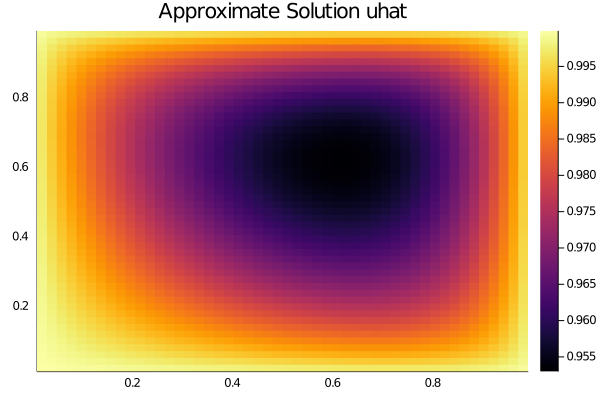

In [223]:
heatmap([i*h for i in 1:m], [j*h for j in 1:m], 
    reverse(U_square, dims = 1),
    title = "Approximate Solution uhat")

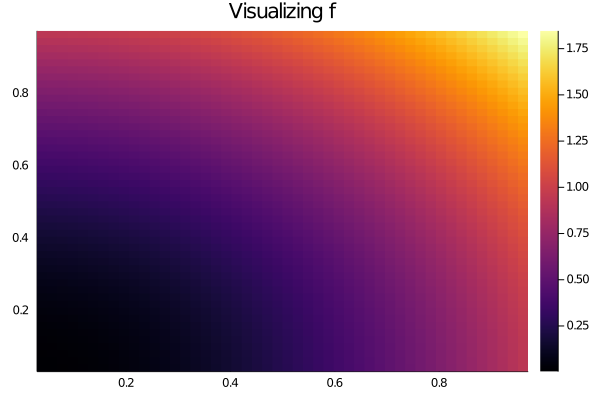

In [224]:
# Plot excludes Boundary Conditions so the gradient is clear.
heatmap([i*h for i in 2:(m-1)], [j*h for j in 2:(m-1)], 
    reverse(makePoissonf(m)[2:(m-1),2:(m-1)], dims = 1),
    title = "Visualizing f")

In [225]:
function compare_sol(A_fine, A_coarse)
    
    m_fine = size(A_fine)[1]
    m_coarse= size(A_coarse)[1]
    
    mag_diff = Int((m_fine + 1)/ (m_coarse + 1))
    
    curr_norm = 0
    for i in 1:(m_coarse - 1)
        for j in 1:(m_coarse -1)
            #curr_norm = maximum( [abs(A_fine[i*mag_diff,j*mag_diff] - A_coarse[i,j]), curr_norm])
            curr_norm += (A_fine[i*mag_diff,j*mag_diff] - A_coarse[i,j])^2 
        end
    end
    
    return  sqrt(curr_norm / (m_coarse + 1) )
end

compare_sol (generic function with 1 method)

In [226]:
# Defining fine grid
m_fine = 2^7 - 1
U_fine = make_U(m_fine);

In [227]:
# Comparing Fine and Coarse Grids
norm_vec = []
m_coarse_vec = []
for lgm in 3:6
    push!(m_coarse_vec, 2^lgm - 1)
    push!(norm_vec, compare_sol(U_fine, make_U(2^lgm - 1)))    
end

In [228]:
norm_vec

4-element Array{Any,1}:
 0.0014111240628668187
 0.0005366698708931256
 0.00018456150605105314
 5.2483929455128475e-5

In [229]:
# n-fold change between errors
for i in 2:length(norm_vec)
   println(norm_vec[i] / norm_vec[i-1] )
end

0.38031374066631324
0.34390137412392097
0.2843709426634742


It seems that error decreases by a factor of 1/4 as the size of $h$ halves. Running this method for bigger than 2^8 gives my computer trouble. The accuracy appears to be increasing as $h$ increasing and I'd say this method appears to be second order accurate as h increases.

# Exerise 3. Adding 9-point with correction

In [230]:
# Here, we need to change the the 9-point approximation 

In [231]:
function makePoissonA9(m)
    h = 1/(m+1)    
    
    T = Tridiagonal(ones(m-1), 10*ones(m), ones(m-1))
    S = Tridiagonal(-(1/2)*ones(m-1), ones(m), -(1/2)*ones(m-1))
    A = -(kron(S, T) + kron(T, S)) / 6h^2
    return A
end

makePoissonA9 (generic function with 1 method)

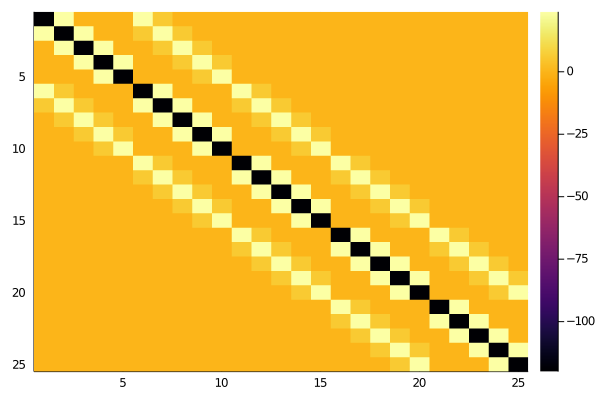

In [232]:
heatmap(makePoissonA9(5), yflip = true)

In [233]:
function makePoissonf9(m) 
    F = zeros(m,m)
    h = 1/(m+1)

    for i in 1:m
        for j in 1:m
            F[i,j] = (i*h)^2 + (j*h)^2 #x^2 + y^2
            F[i,j] += h^2/3 #Laplacian of x^2 + y^2 is 4
        end
    end
        
    # Add in Dirichlet Boundary Condititions
    # Left and right grid sides
    # Top and Bottom of Grid
    for i in 1:m
        F[i, 1] -= 1/(h^2)
        F[i, end] -= 1/(h^2)
        F[1, i] -= 1/(h^2)
        F[end,i] -= 1/(h^2)  
    end
    
    # Corners have additional term
    F[1,1] += 1/(6h^2)
    F[1,end] += 1/(6h^2)
    F[end,1] += 1/(6h^2)
    F[end,end] += 1/(6h^2)
    
    return reverse(F, dims = 1)
end


makePoissonf9 (generic function with 1 method)

In [234]:
function make_U9(m)
    A = sparse(makePoissonA9(m))
    F = reshape(rotr90(makePoissonf9(m)), m^2)
    U_square = reverse(reshape(A \ F, m, m), dims = 1)
    return U_square
end

make_U9 (generic function with 1 method)

In [235]:
m = 80
h = 1/(m+1)
U_square = make_U9(m);

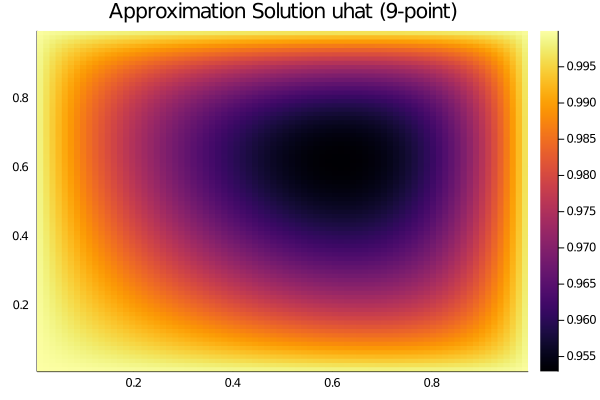

In [236]:
heatmap([i*h for i in 1:m], [j*h for j in 1:m], 
    reverse(U_square, dims = 1),
    title = "Approximation Solution uhat (9-point)")

In [237]:
# Defining fine grid
U_fine = make_U9(2^7 - 1);

In [238]:
# Comparing Fine and Coarse Grids
norm_vec = []
m_coarse_vec = []
for lgm in 3:6
    push!(m_coarse_vec, 2^lgm - 1)
   push!(norm_vec, compare_sol(U_fine, make_U9(2^lgm - 1)))
end

In [239]:
norm_vec

4-element Array{Any,1}:
 1.4044198888024176e-5
 2.359901278882616e-6
 4.0792053720953293e-7
 6.760555279892312e-8

In [240]:
# n-fold change between errors
for i in 2:length(norm_vec)
   println(norm_vec[i] / norm_vec[i-1] )
end

0.16803388343460163
0.17285491594914437
0.16573216259566942


It seems that error decreases by a factor of approximately 1/8 as the size of $h$ halves. Running this method for bigger than 2^8 gives my computer trouble but based on what I'm observing. The accuracy appears to be increasing as $h$ increasing and I'd say this method appears to be a certainly better than second order accurate as h increases but not quite 4th order as expected.